In [1]:
import os
import inspect
import sys

In [2]:
import sys
sys.path.append("../")
sys.path.append('../../../')

In [3]:
from gnn_boundary.datasets import *
from gnn_boundary.models import *
from gnn_boundary.utils import *
from gnn_boundary.criteria import *
from gnn_boundary.regularizations import *
from gnn_boundary import Trainer, Evaluator, GraphSampler

import shelve
import torch
import numpy as np

from DatasetWrapper import *

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from graph_generation import HouseSet as GG

[Data(x=[3, 3], edge_index=[2, 6], y=[1])]


In [5]:
dataset = GG.HouseSetCreator(100, 30, 2.5*30).getDataset()
num_cls = 2

In [6]:
dataset = DatasetWrapper(dataset, num_cls=2, node_feat= 3,name="houses")

In [7]:
import explainers.GNNBoundary.gnn_boundary.models as models

In [8]:
model = models.GCNClassifier(hidden_channels = 32, node_features = 3, num_classes=2)

In [9]:
import os
cwd = os.getcwd()
file_path = os.path.abspath(os.path.join(cwd, '../../../model/report_models/house.pt'))

In [10]:
model.load_state_dict(torch.load(file_path))

<All keys matched successfully>

In [11]:
dataset_list_gt = dataset.split_by_class()
dataset_list_pred = dataset.split_by_pred(model)

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\data\in_memory_dataset.py:300: UserWarning: It is not recommended to directly access the internal storage format `data` of an 'InMemoryDataset'. If you are absolutely certain what you are doing, access the internal storage via `InMemoryDataset._data` instead to suppress this warning. Alternatively, you can access stacked individual attributes of every graph via `dataset.{attr_name}`.
  warnings.warn(msg)
C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [12]:
evaluation = dataset.model_evaluate(model)
evaluation

{'acc': 0.9517999887466431,
 'cm': array([[2060,  385],
        [  97, 7458]], dtype=int64),
 'f1': {0: 0.8952629566192627, 1: 0.9686972498893738}}

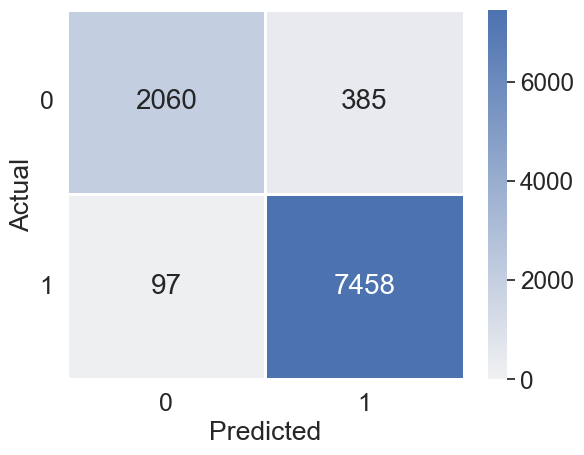

In [13]:
draw_matrix(evaluation['cm'], dataset.GRAPH_CLS.values(), fmt='d')

In [14]:
mean_embeds = [d.model_transform(model, key="embeds").mean(dim=0) for d in dataset_list_gt]

C:\Users\hanne\anaconda3\envs\gnnboundary\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


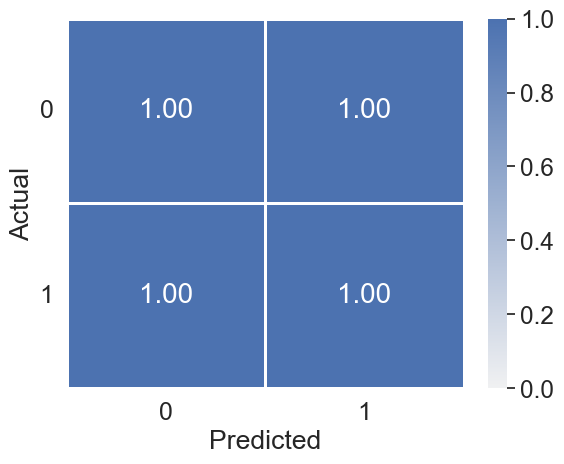

In [15]:
adj_ratio_mat, boundary_info = pairwise_boundary_analysis(model, dataset_list_pred)
draw_matrix(adj_ratio_mat, names=dataset.GRAPH_CLS.values(), fmt='.2f')

In [16]:
from utility_functions import *

In [17]:
trainer = {}
sampler = {}

In [18]:
from gnn_boundary import Trainer

In [19]:
def hyperparameterBoundary(max_nodes, lr, target_size):
    cls_1, cls_2 = 0, 1
    trainer[cls_1, cls_2] = Trainer(
        sampler=(s := GraphSampler(
            max_nodes=max_nodes,
            temperature=0.5,
            num_node_cls=3,#len(dataset.NODE_CLS),
            learn_node_feat=True
        )),
        discriminator=model,
        criterion=WeightedCriterion([
            dict(key="logits", criterion=DynamicBalancingBoundaryCriterion(
                classes=[cls_1, cls_2], alpha=1, beta=2
            ), weight=25),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_1]), weight=0),
            dict(key="embeds", criterion=EmbeddingCriterion(target_embedding=mean_embeds[cls_2]), weight=0),
            dict(key="logits", criterion=MeanPenalty(), weight=1),
            dict(key="omega", criterion=NormPenalty(order=1), weight=1),
            dict(key="omega", criterion=NormPenalty(order=2), weight=1),
            # dict(key="xi", criterion=NormPenalty(order=1), weight=0),
            # dict(key="xi", criterion=NormPenalty(order=2), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=1), weight=0),
            # dict(key="eta", criterion=NormPenalty(order=2), weight=0),
            dict(key="theta_pairs", criterion=KLDivergencePenalty(binary=True), weight=0),
        ]),
        optimizer=(o := torch.optim.SGD(s.parameters(), lr=lr)),
        scheduler=torch.optim.lr_scheduler.ExponentialLR(o, gamma=1),
        dataset=dataset,
        budget_penalty=BudgetPenalty(budget=10, order=2, beta=1),
    )
    
    trainer[0, 1].train(
        iterations=1000,
        target_probs={cls_1: (0.3, 0.7), cls_2: (0.3, 0.7)},
        target_size= target_size,
        w_budget_init=1,
        w_budget_inc=1.1,
        w_budget_dec=0.95,
        k_samples=16
    )

    explain_graph = trainer[0, 1].evaluate(threshold=0.5, show=False)
    graph = dataset.convertNxToData(explain_graph)
    return graph
    


In [20]:
max_nodes_li = [15, 20, 25]
lr_li = [0.5,0.05, 0.005]
target_size_li = [15,25,30]
class_1 = 0
class_2 = 1


In [21]:
criteria_function = lambda x,y: (1-x)**2 + (1-y)**2

best_probs = (0,1)
best_graph = None
best_hyperparameters = (0,0,0)
for max_nodes in max_nodes_li:
    for lr in lr_li:
        for target_size in target_size_li:
            try:
                graph = hyperparameterBoundary(max_nodes = max_nodes,lr = lr, target_size = target_size)
                probs = (model(graph)["probs"].squeeze()[class_1].item(),model(graph)["probs"].squeeze()[class_2].item())
                print(f"MN: {max_nodes} LR: {lr} TS: {target_size} Probs: {probs}")
                if criteria_function(*best_probs) > criteria_function(*probs):
                    best_probs = probs
                    best_graph = graph
                    best_hyperparameters = (max_nodes, lr, target_size)
            except Exception as e:
                if str(e) == "Empty graph!":
                    print("Caught an Empty graph exception")
                    print(f"MN: {max_nodes} LR: {lr} TS: {target_size}")
                



  1%|▏         | 14/1000 [00:00<00:31, 31.75it/s]


MN: 15 LR: 0.5 TS: 15 Probs: (0.9933700561523438, 0.006629973649978638)


  1%|          | 11/1000 [00:00<00:32, 30.65it/s]


MN: 15 LR: 0.5 TS: 25 Probs: (0.9913967251777649, 0.008603256195783615)


  2%|▏         | 15/1000 [00:00<00:29, 33.31it/s]


MN: 15 LR: 0.5 TS: 30 Probs: (0.9912294149398804, 0.008770644664764404)


  3%|▎         | 32/1000 [00:00<00:25, 38.52it/s]


MN: 15 LR: 0.05 TS: 15 Probs: (0.9743330478668213, 0.025666961446404457)


  0%|          | 5/1000 [00:00<00:43, 22.69it/s]


MN: 15 LR: 0.05 TS: 25 Probs: (0.5312655568122864, 0.46873441338539124)


  1%|          | 9/1000 [00:00<00:34, 28.56it/s]


MN: 15 LR: 0.05 TS: 30 Probs: (0.9975590705871582, 0.002440882148221135)


 24%|██▎       | 237/1000 [00:05<00:18, 40.90it/s]


MN: 15 LR: 0.005 TS: 15 Probs: (0.9706271290779114, 0.029372913762927055)


 56%|█████▌    | 557/1000 [00:12<00:10, 43.65it/s]


MN: 15 LR: 0.005 TS: 25 Probs: (0.9996176958084106, 0.00038226915057748556)


 36%|███▌      | 355/1000 [00:08<00:14, 43.70it/s]


MN: 15 LR: 0.005 TS: 30 Probs: (0.9994927644729614, 0.000507200020365417)


  5%|▍         | 49/1000 [00:01<00:31, 30.64it/s]


MN: 20 LR: 0.5 TS: 15 Probs: (0.965465784072876, 0.034534212201833725)


 60%|█████▉    | 599/1000 [00:17<00:11, 35.02it/s]


MN: 20 LR: 0.5 TS: 25 Probs: (0.9968761205673218, 0.003123911563307047)


  6%|▌         | 57/1000 [00:01<00:28, 32.75it/s]


MN: 20 LR: 0.5 TS: 30 Probs: (0.9537363648414612, 0.046263668686151505)


  5%|▍         | 47/1000 [00:01<00:29, 32.03it/s]


MN: 20 LR: 0.05 TS: 15 Probs: (0.9941855072975159, 0.005814554635435343)


  4%|▍         | 45/1000 [00:01<00:31, 30.32it/s]


MN: 20 LR: 0.05 TS: 25 Probs: (0.9794623255729675, 0.020537646487355232)


  3%|▎         | 30/1000 [00:01<00:39, 24.47it/s]


MN: 20 LR: 0.05 TS: 30 Probs: (0.9777171611785889, 0.022282835096120834)


100%|██████████| 1000/1000 [00:25<00:00, 39.41it/s]


MN: 20 LR: 0.005 TS: 15 Probs: (1.0, 1.8400847276213482e-19)


100%|██████████| 1000/1000 [00:26<00:00, 37.60it/s]


MN: 20 LR: 0.005 TS: 25 Probs: (1.0, 9.769515383305227e-14)


 28%|██▊       | 281/1000 [00:08<00:21, 33.98it/s]


MN: 20 LR: 0.005 TS: 30 Probs: (0.9997814297676086, 0.0002185883786296472)


  1%|          | 12/1000 [00:01<01:34, 10.40it/s]


MN: 25 LR: 0.5 TS: 15 Probs: (0.926550030708313, 0.07344992458820343)


  2%|▏         | 19/1000 [00:01<01:14, 13.22it/s]


MN: 25 LR: 0.5 TS: 25 Probs: (0.9537363648414612, 0.046263668686151505)


  2%|▏         | 23/1000 [00:01<01:11, 13.75it/s]


MN: 25 LR: 0.5 TS: 30 Probs: (0.9983532428741455, 0.0016467244131490588)


 16%|█▋        | 164/1000 [00:05<00:29, 28.42it/s]


MN: 25 LR: 0.05 TS: 15 Probs: (0.9999998807907104, 1.1201286298501145e-07)


  2%|▏         | 22/1000 [00:01<01:07, 14.54it/s]


MN: 25 LR: 0.05 TS: 25 Probs: (0.9645271897315979, 0.03547273576259613)


  3%|▎         | 27/1000 [00:01<01:04, 15.11it/s]


MN: 25 LR: 0.05 TS: 30 Probs: (0.9482791423797607, 0.05172085762023926)


100%|██████████| 1000/1000 [00:30<00:00, 32.85it/s]


MN: 25 LR: 0.005 TS: 15 Probs: (1.0, 1.8400847276213482e-19)


100%|██████████| 1000/1000 [00:31<00:00, 31.74it/s]


MN: 25 LR: 0.005 TS: 25 Probs: (1.0, 1.4116444124745442e-11)


 51%|█████     | 507/1000 [00:14<00:14, 34.35it/s]

MN: 25 LR: 0.005 TS: 30 Probs: (0.9999172687530518, 8.274250285467133e-05)


(0.5312655568122864, 0.46873441338539124)
(15, 0.05, 25)


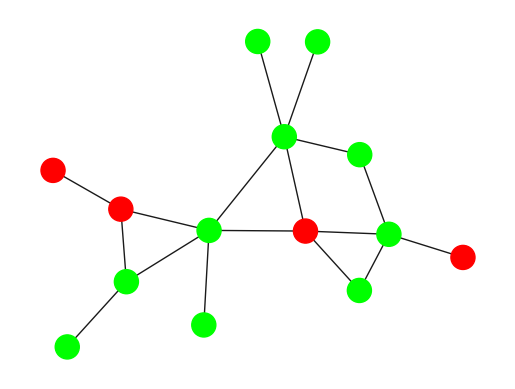

In [22]:
print(best_probs)
print(best_hyperparameters)
printGraph(best_graph, "./images/HouseBoundary")